In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [4]:
hydrogen_wgt = 1.008 #IUPAC
atomic_wgts = np.array([15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
asplund = np.array([8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
a = sum(10**(asplund-12.00)*(atomic_wgts/hydrogen_wgt)*(1/0.0181)) # a = 0.78963627131196057
b = 1-a # b = 0.21036372868803943
print(a)
print(b)
print('Original Salaris a: ',0.638)
print('Original Salaris b: ',0.362)

0.5605413030674107
0.4394586969325893


In [41]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.salfeh = abund[0]+np.log10(0.638*(10**(abund[1]))+0.362) # Salaris Corrected [Fe/H]
#         self.salfeh_err =  # Salaris Corrected [Fe/H] Error
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
#         self.wang = {'abpak':/0.078,'arpak':/0.078,'ajak':/0.078,'ahak':/0.078,'akak':1.0}
    
#     def salariscorrectedfeh(self,abund):
#         '''
#         Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
#         Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
#         # hydrogen_wgt = 1.008 #IUPAC
#         # atomic_wgts = np.array([15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
#         # asplund = np.array([8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
#         # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
#         # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
#         # b = 1-a # b = 0.21036372868803943
        
#         Inputs:
#         ------
#             feh: metallcity of a star
#             _alpha: array of abundances np.array([O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
#         Output:
#         ------
#             salfeh: Salaris corrected metallicity
#         '''
        
#         # Set things up
#         nsamples = 1000
#         asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
#         feh = abund[0,0]
#         feh_err = abund[0,1]
#         _alpha = abund[1:,0]
#         _alpha_err = abund[1:,1]
        
#         salfehdist = 999999.0*np.ones(nsamples)
        
#         for i in range(nsamples):
        
#             # Assign solar value to stars if abundance is bad
#             for j in range(len(_alpha)):
#                 if _alpha[j] < -100. or _alpha[j] > 10. or np.isfinite(_alpha[j])==False:
#                     _alpha[j] = 0.0
#                 if _alpha_err[j] < -100. or _alpha_err[j] > 10. or np.isfinite(_alpha_err[j])==False:
#                     _alpha_err[j] = 0.0

#             if np.isfinite(feh) == False:
#                 feh = 0.0
#                 feh_err = 0.0

#             # Create distribution for the different abundances
#             feh_new = np.random.normal(feh,feh_err)
#             _alpha_new = 999999.0*np.ones(len(_alpha))
#             for k in range(len(_alpha)):
#                 _alpha_new[k] = np.random.normal(_alpha[k],_alpha_err[k])
            
#             # Calculate enhancement factor and corrected metallicity
#             fac_acn = sum(10**(asplund+_alpha_new))/sum(10**asplund)
#             salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
            
#             salfehdist[i] = salfeh
        
#         # Calculate the value and error from the distribution
#         calc_salfeh = np.nanmedian(salfehdist)
#         calc_salfeh_err = self.mad(salfehdist)
        
#         return calc_salfeh, calc_salfeh_err 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav    
        
    def teff_2_appmags(self,teff,age,ak,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
    
    def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_aks = []
        curve_ages_err = []
        curve_aks_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            for k in range(len(guess_aks)):  
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
                                          bounds=((0.,0.),(17.,2.)),method='trf',sigma=self.phot_err,
                                          absolute_sigma=True,maxfev=5000)

                    # populate lists
                    curve_ages.append(popt[0])
                    curve_aks.append(popt[1])
                    curve_ages_err.append(np.sqrt(pcov[0][0]))
                    curve_aks_err.append(np.sqrt(pcov[1][1]))
                    curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
                    curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

                except:
                    #populate lists
                    curve_mags = 999999.0*np.ones(5)
                    curve_ages.append(999999.0)
                    curve_aks.append(999999.0)
                    curve_ages_err.append(999999.0)
                    curve_aks_err.append(999999.0)
                    curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        ak = np.asarray(curve_aks)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        ak_err = np.asarray(curve_aks_err)[idx]

        best_params = np.array([age,ak])
        best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff2appmags(self.teff,age,ak)

        if verbose:
            print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
            print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params, best_params_err
        
#     def diagnostic(self,best_fit_params,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age and Ak values that is optionally saved
        
#         Inputs:
#         ------
#             best_fit_params: [array]
#             lit_age: [float] optional known literature age in Gyr
#             filename: [str] optional filename of plot if saving
#         '''
        
#         # initialize arrays
#         ages = np.arange(0,15,0.25)
#         theos = 999999.0*np.ones((len(ages),5))
#         theos_noext = 999999.0*np.ones((len(ages),5))
    
#         # calculate theoretical age for given ages
#         for j in range(len(ages)):
#             theos[j,:] = self.teff2appmags(self.teff,ages[j],best_fit_params[1]) # use best Ak 
#             theos_noext[j,:] = self.teff2appmags(self.teff,ages[j],0) # no extinction
        
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for i in range(5):
#             ax[i].scatter(theos[:,i],ages,s=100,label='Best Fit Ak')
#             ax[i].plot(theos[:,i],ages)
            
#             ax[i].scatter(theos_noext[:,i],ages,s=100,label='No Ak')
#             ax[i].plot(theos_noext[:,i],ages)
            
#             ax[i].axhline(best_fit_params[0],c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age!=None:
#                 ax[i].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
            
#             ax[i].axvline(self.phot[i],ls='--',c='magenta',lw=3.0)
            
#             ax[i].set_xlim(self.phot[i]-3.0,self.phot[i]+3.0)
#             ax[i].set_ylim(bottom=0.01)
            
#             ax[i].set_title(r'{}: {:.3f}'.format(self.labels[i],self.phot[i]))
#             ax[i].set_xlabel(r'Magnitude')
            
#         ax[0].legend()

#         ax[0].set_ylabel('Age')
        
#         if star_name!=None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_params[0],
#                                                                           best_fit_params[1],self.distance))
        
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_params[0],best_fit_params[1],
#                                                                       self.distance))
    
#         if filename!=None:
#             plt.savefig(filename,bbox_inches='tight')
#         plt.show()
        
    def get_ak(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        akdist = 999999.0*np.ones(nsamples)

        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]

                ### use a spline to get the intrinsic color and calculate the reddening
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print(ccm)
                    print(np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)
                akdist[j] = calc_ak

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)   
                    akdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                    color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                    age_spl_interp = np.poly1d(np.squeeze(
                        np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
                    if verbose:
                        print('interp',age_spl_interp)
                        print('logteff',lgteffdist[j])
                        print('interp age',age_spl_interp(lgteffdist[j]))
                        print('color',self.phot[i]-self.phot[4])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))
                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print('CCM: ',ccm)
                    print('Ak each band',np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)

#                 print(calc_ak)
                akdist[j] = calc_ak
            
#         print(akdist)
        med_calc_ak = np.nanmedian(akdist)
        mad_calc_ak = self.mad(akdist)
        
        if np.isfinite(med_calc_ak)==False:
            med_calc_ak = 999999.0
        if np.isfinite(mad_calc_ak)==False:
            mad_calc_ak = 999999.0
        
        self.ak = med_calc_ak
        self.ak_err = mad_calc_ak
        
        return np.array([med_calc_ak,mad_calc_ak])

    def teff_2_appmags_age(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
        
    def get_age(self,guess_ages=np.arange(0,17),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_ages_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags_age,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,17.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_mags = np.asarray(self.teff_2_appmags_age(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        age_err = np.asarray(curve_ages_err)[idx]

        best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

        if verbose:
            print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
            print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params
    
#     def test(self,x=3.0):
#         print('Hello World!')
    
    def age_diagnostic(self,best_fit_age,star_name=None,lit_age=None,filename=None,verbose=False):
        '''
        Create a diagnostic plot for the best fit age
        
        Inputs:
        ------
            best_fit_age: best fit age in Gyr
            star_name: name of star
            lit_age: known literature age in Gyr
            filename: name of file if saving plot
        '''
        
        # intialize arrays
        ages = np.arange(0,15,0.25)
        theos_w_ext = 999999.0*np.ones((len(ages),5))
        theos_wo_ext = 999999.0*np.ones((len(ages),5))
        
        # Calculate theoretical mags given an age in ages
        for i in range(len(ages)):
            theos_w_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],self.ak)
            theos_wo_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],0)
            
        # plot results
        fig, ax = plt.subplots(1,5,figsize=[67,15])
        for j in range(5):
            # with extinction
            ax[j].scatter(theos_w_ext[:,j],ages,s=100,label='Best Fit Ak')
            ax[j].plot(theos_w_ext[:,j],ages)
            
            # without extinction
            ax[j].scatter(theos_wo_ext[:,j],ages,s=100,label='No Ak')
            ax[j].plot(theos_wo_ext[:,j],ages)
            
            ax[j].axhline(best_fit_age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
            if lit_age != None:
                ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
            ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
#             ax[j].set_xlim(self.phot[j]-3.0,self.phot[j]+3.0)
            ax[j].set_xlim(-14,14)
            ax[j].set_ylim(bottom=0.01)
            
            ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
            ax[j].set_xlabel(r'Magnitude')
        
        ax[0].legend()
        
        ax[0].set_ylabel('Age')
        
        if star_name != None:
            plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_age,
                                                                          self.ak,self.distance))
            
        else:
            plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_age,self.ak,
                                                                      self.distance))
            
        if filename != None:
            plt.savefig(filename,bbox_inches='tight')
            
        plt.show()

In [6]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC 

In [7]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_3_5.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']#,'label']

# APOKASC

In [11]:
kasc = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')

### DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, kasc_ind, dr17_ind = np.intersect1d(kasc['2MASS_ID'], dr17['APOGEE_ID'], return_indices=True)

kascdr17 = dr17[dr17_ind]
kasc = kasc[kasc_ind]

# Gaia Errors

In [12]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

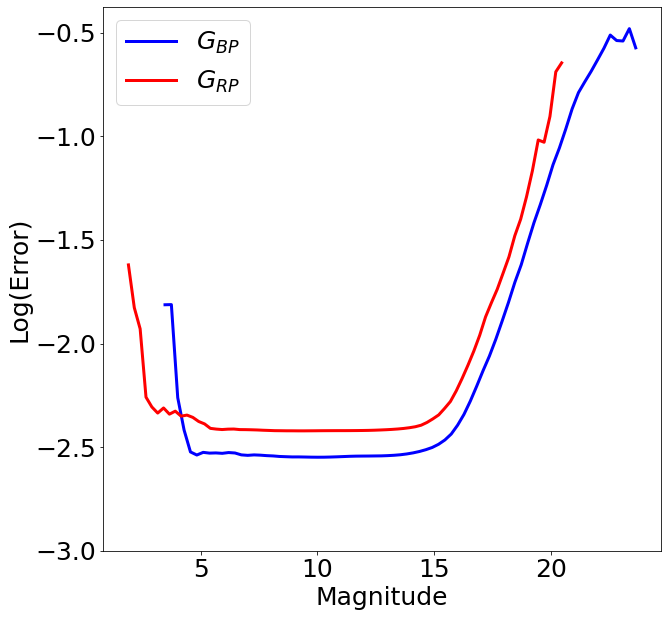

In [13]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kascdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kascdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# APOKASC Exploration

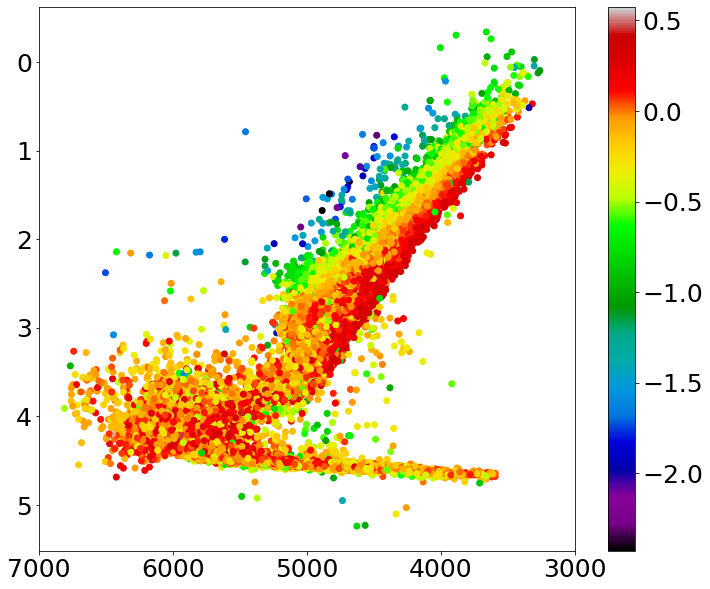

In [14]:
good = np.where((kascdr17['TEFF']>-100.)&(kascdr17['LOGG']>-100.))
plt.figure(figsize=[12,10])
plt.scatter(kascdr17['TEFF'][good],kascdr17['LOGG'][good],
            c=kascdr17['FE_H'][good],cmap='nipy_spectral')
plt.colorbar()
plt.xlim(3000,7000)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

2216


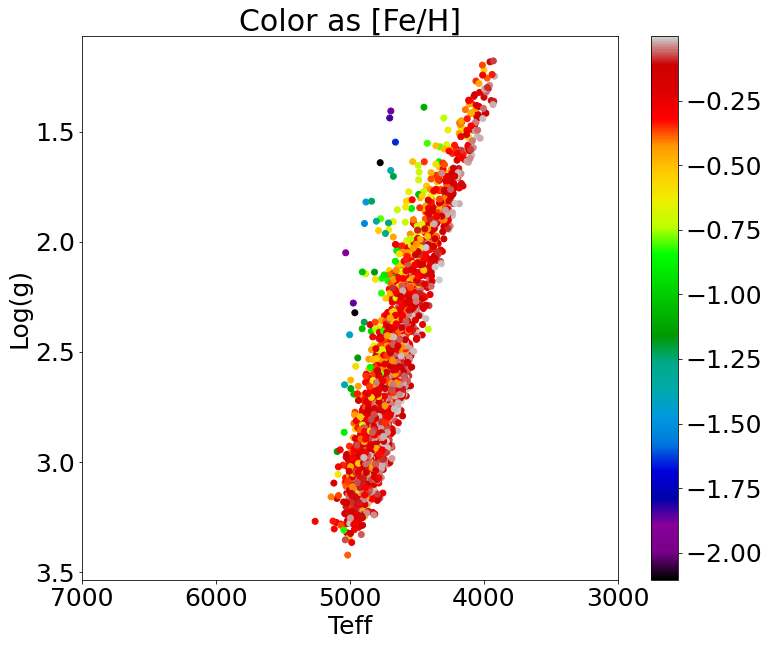

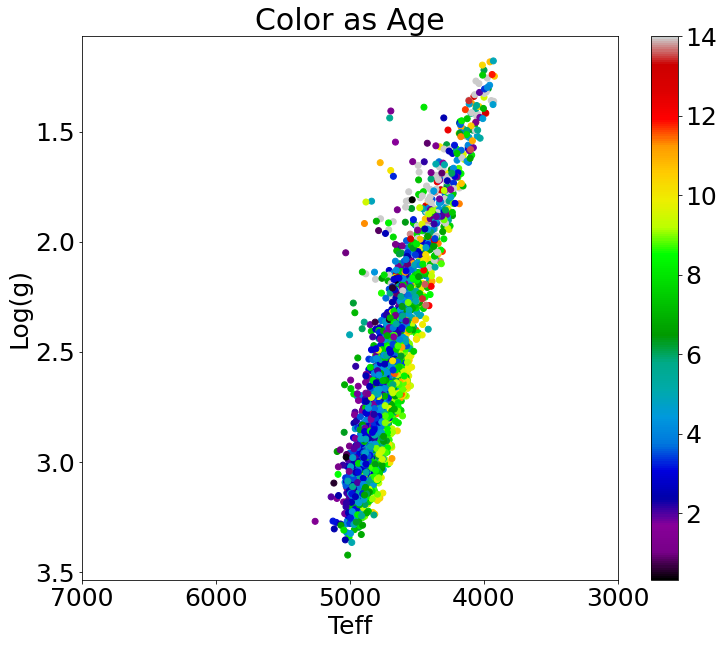

In [15]:
ageevs = np.where((kasc['APOKASC2_AGE']>-100.)&(kasc['APOKASC3_CONS_EVSTATES']==1.0)&(kascdr17['FE_H']<=0.0)&
                  (kascdr17['GAIAEDR3_PARALLAX']/kascdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

print(len(np.squeeze(ageevs)))

plt.figure(figsize=[12,10])
plt.scatter(kascdr17['TEFF'][ageevs],kascdr17['LOGG'][ageevs],
            c=kascdr17['FE_H'][ageevs],cmap='nipy_spectral')
plt.colorbar()
plt.xlim(3000,7000)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(kascdr17['TEFF'][ageevs],kascdr17['LOGG'][ageevs],
            c=kasc['APOKASC2_AGE'][ageevs],cmap='nipy_spectral',vmax=14.0)
plt.colorbar()
plt.xlim(3000,7000)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

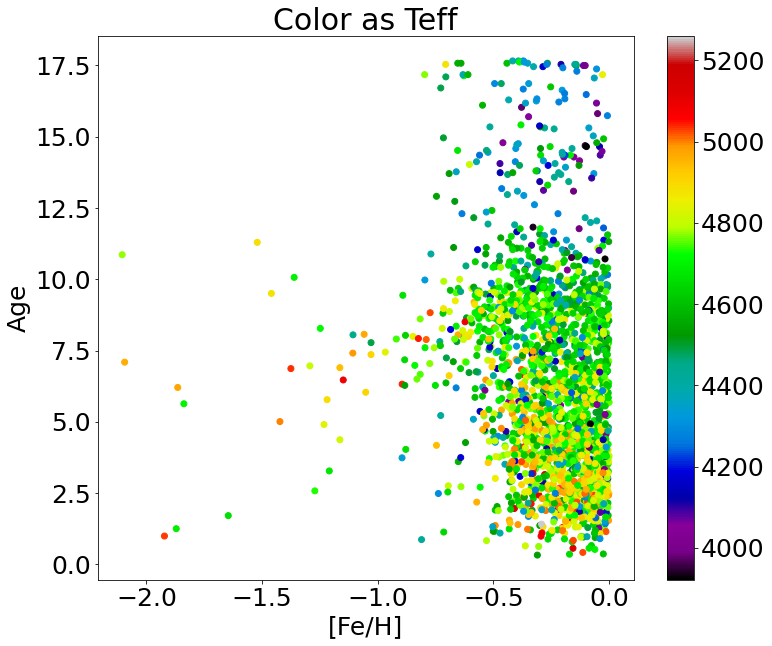

In [16]:
plt.figure(figsize=[12,10])
plt.scatter(kascdr17['FE_H'][ageevs],kasc['APOKASC2_AGE'][ageevs],c=kascdr17['TEFF'][ageevs],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Teff')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Age')
plt.show()

Text(0.5, 0, 'Age')

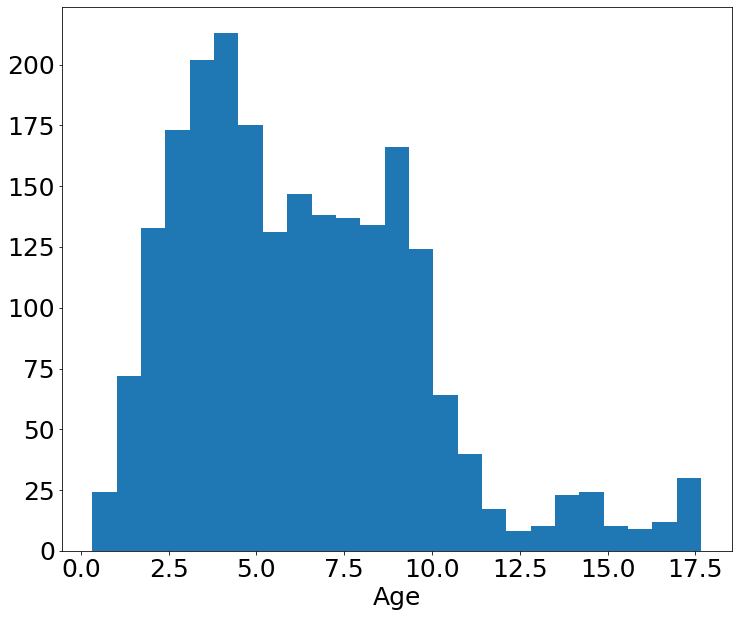

In [19]:
plt.figure(figsize=[12,10])
plt.hist(kasc['APOKASC2_AGE'][ageevs],bins=25)
plt.xlabel(r'Age')

In [42]:
kasc_ak = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_ak_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age_err = 999999.0*np.ones(len(np.squeeze(ageevs)))

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    te = np.array([kascdr17['TEFF'][ageevs][i],kascdr17['TEFF_ERR'][ageevs][i]])
    ab = np.array([kascdr17['M_H'][ageevs][i],kascdr17['ALPHA_M'][ageevs][i]])
    op = np.array([[kascdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][ageevs][i],
                    kascdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][ageevs][i],
                    kascdr17['J'][ageevs][i],kascdr17['H'][ageevs][i],
                    kascdr17[ageevs]['K'][i]],
                   [bperr[ageevs][i],rperr[ageevs][i],kascdr17['J_ERR'][ageevs][i],
                    kascdr17['H_ERR'][ageevs][i],kascdr17['K_ERR'][ageevs][i]]]).T
    di = (1/kascdr17['GAIAEDR3_PARALLAX'][ageevs][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    kasc_ak[i] = CalcAge.get_ak(age = 6.0)[0]
    kasc_ak_err[i] = CalcAge.get_ak(age = 6.0)[1]
    
    kasc_age[i] = CalcAge.get_age()[0]
    kasc_age_err[i] = CalcAge.get_age()[1]

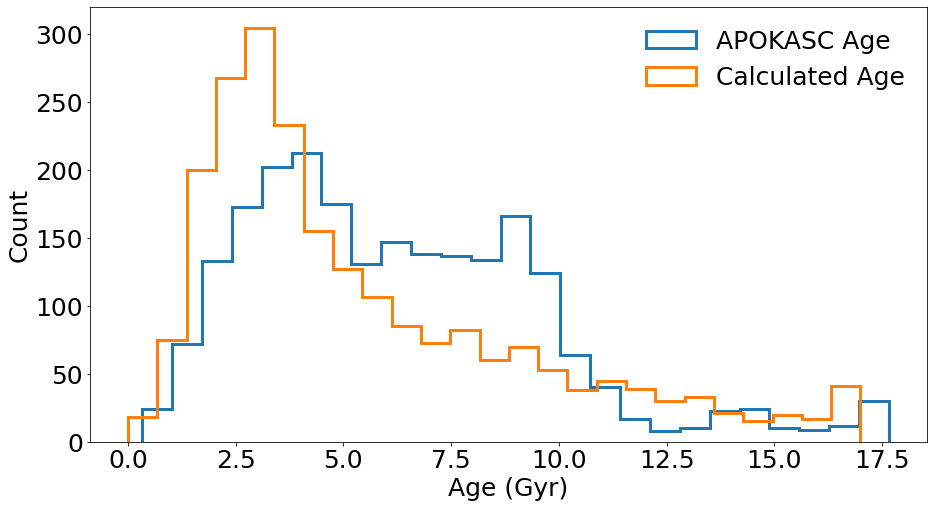

In [44]:
plt.figure(figsize=[15,8])
plt.hist(kasc['APOKASC2_AGE'][ageevs],bins=25,density=False,histtype='step',lw=3.0,label='APOKASC Age')
plt.hist(kasc_age,range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='Calculated Age')
plt.legend(frameon=False)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Count')
plt.savefig('../plots/agehistogram_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

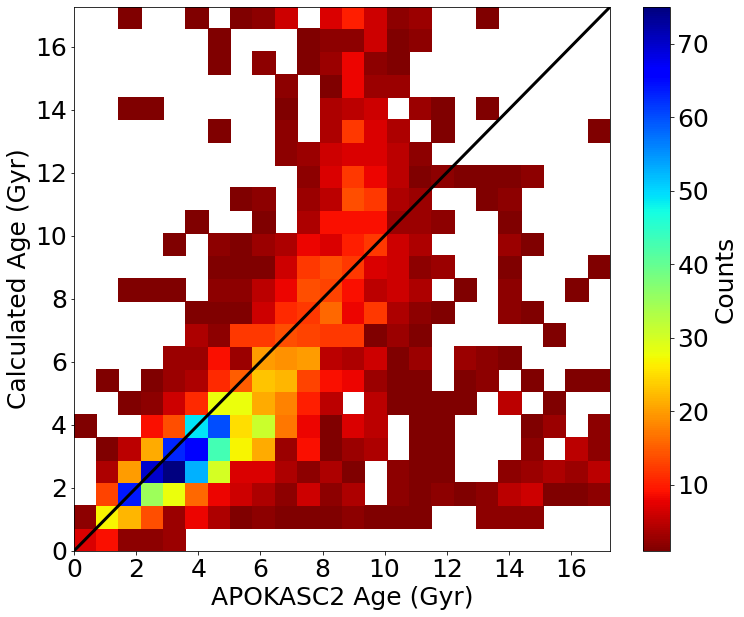

In [61]:
badcut = np.where(kasc_age<999999.0)

x = kasc['APOKASC2_AGE'][ageevs][badcut]
y = kasc_age[badcut]
xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[12,10])
plt.hist2d(x,y,bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.plot([0,18],[0,18],c='k',lw=3.0)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC2 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('../plots/apokascvalidation_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

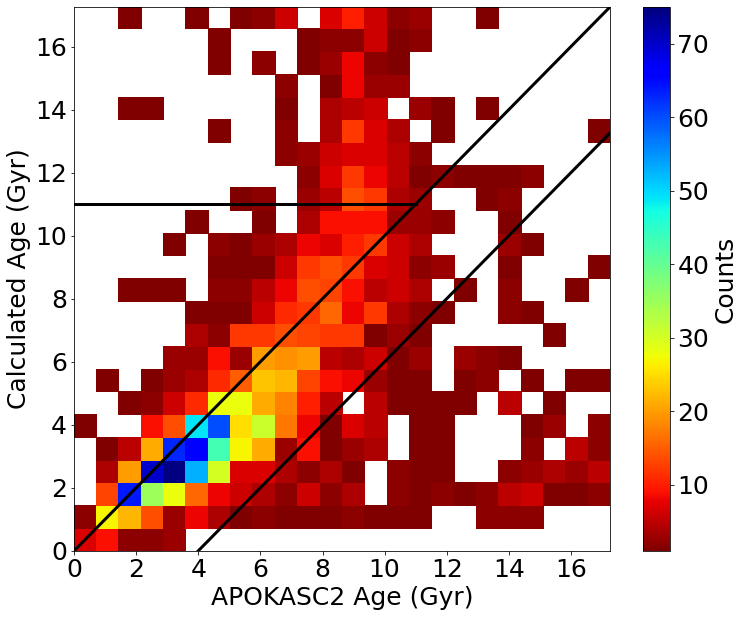

In [62]:
plt.figure(figsize=[12,10])
plt.hist2d(x,y,bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.plot([0,18],[0,18],c='k',lw=3.0)
plt.plot([4,17.25],[0,13.25],lw=3.0,c='k')
plt.plot([0,11],[11,11],lw=3.0,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC2 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.show()

In [63]:
def upturn10Gyr(age):
    '''
    Boundary for 10 Gyr upturn in Aetas and APOKASC plot 
    
    Input:
    -----
        age: age in Gyr
        
    Output:
    ------
        ups: value on boundary 
    '''
    ups = np.ones(np.size(age))
    for i in range(np.size(age)):
        if age[i] <= 10:
            up = 10

        else:
            up = age[i]
            
        ups[i] = up

    return ups

def oldapokasc(age):
    '''
    Boundary for old stars in APOKASC given young age by Aetas
    
    Input:
    -----
        age: age in Gyr
    
    Output:
    ------
        olds: value on boundary
    '''
    olds = np.ones(np.size(age))
    for i in range(np.size(age)):
        olds[i] = age[i] - 4
        
    return olds

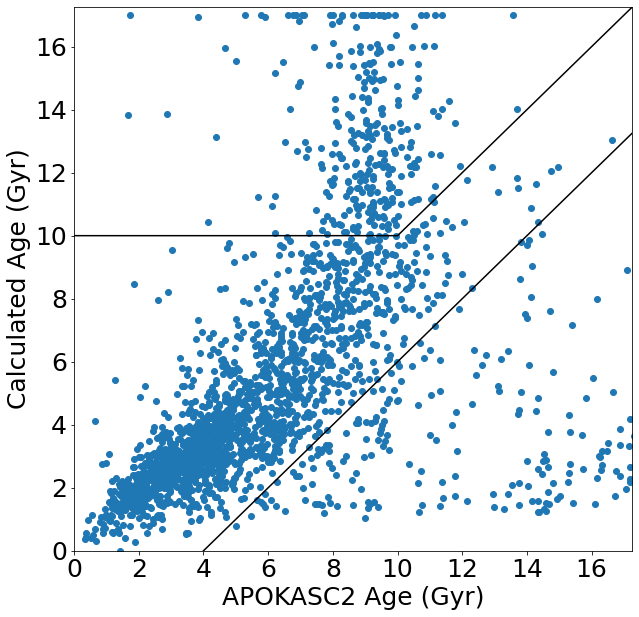

In [64]:
plt.figure(figsize=[10,10])
plt.scatter(x,y)

plt.plot(np.arange(0,18,0.25),upturn10Gyr(np.arange(0,18,0.25)),c='k')
plt.plot(np.arange(0,18,0.25),oldapokasc(np.arange(0,18,0.25)),c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC2 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
plt.show()

In [65]:
upturnstars = np.where(y-upturn10Gyr(x)>0)
oldapokascstars = np.where(y-oldapokasc(x)<0)
goodstars = np.where((y-upturn10Gyr(x)<0)&(y-oldapokasc(x)>0))

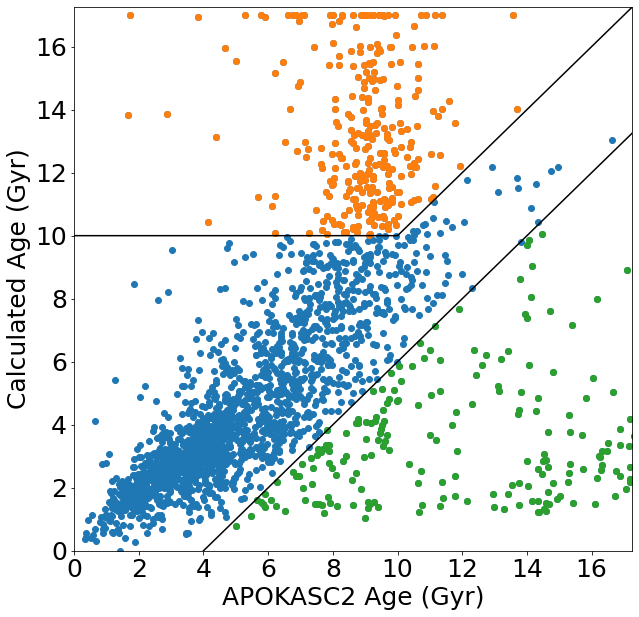

In [66]:
plt.figure(figsize=[10,10])
plt.scatter(x,y,cmap='jet')
plt.scatter(x[upturnstars],y[upturnstars],cmap='jet')
plt.scatter(x[oldapokascstars],y[oldapokascstars],cmap='jet')
# plt.scatter(x[goodstars],y[goodstars],cmap='jet')
# plt.colorbar()

plt.plot(np.arange(0,18,0.25),upturn10Gyr(np.arange(0,18,0.25)),c='k')
plt.plot(np.arange(0,18,0.25),oldapokasc(np.arange(0,18,0.25)),c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC2 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
plt.show()

Text(0, 0.5, '[$\\alpha$/Fe]')

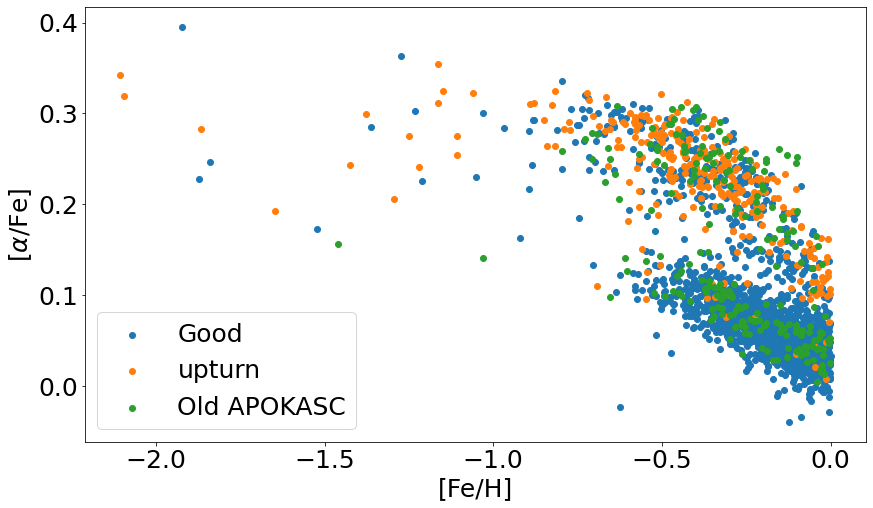

In [67]:
plt.figure(figsize=[14,8])
plt.scatter(kascdr17['FE_H'][ageevs][badcut][goodstars],
            (kascdr17['ALPHA_M']+kascdr17['M_H']-kascdr17['FE_H'])[ageevs][badcut][goodstars],label='Good')
plt.scatter(kascdr17['FE_H'][ageevs][badcut][upturnstars],
            (kascdr17['ALPHA_M']+kascdr17['M_H']-kascdr17['FE_H'])[ageevs][badcut][upturnstars],label='upturn')
plt.scatter(kascdr17['FE_H'][ageevs][badcut][oldapokascstars],
            (kascdr17['ALPHA_M']+kascdr17['M_H']-kascdr17['FE_H'])[ageevs][badcut][oldapokascstars],
            label='Old APOKASC')
plt.legend()

plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')

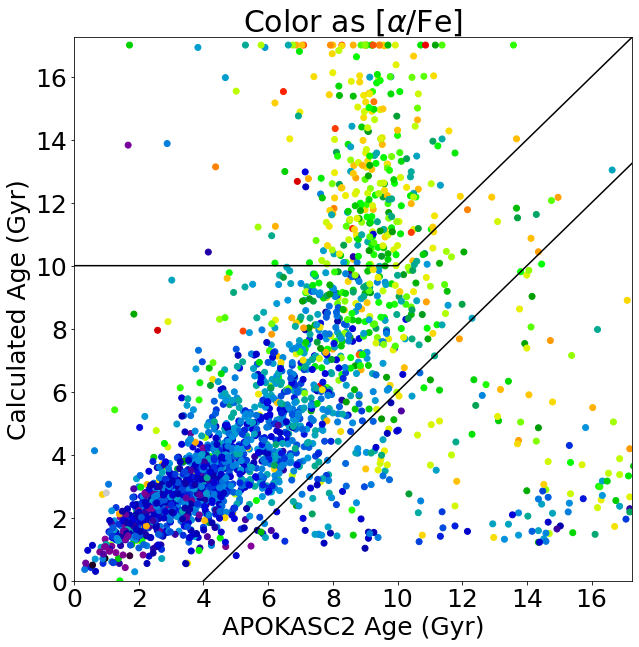

In [68]:
plt.figure(figsize=[10,10])
plt.scatter(x,y,c=(kascdr17['ALPHA_M']+kascdr17['M_H']-kascdr17['FE_H'])[ageevs][badcut],cmap='nipy_spectral')

plt.plot(np.arange(0,18,0.25),upturn10Gyr(np.arange(0,18,0.25)),c='k')
plt.plot(np.arange(0,18,0.25),oldapokasc(np.arange(0,18,0.25)),c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.title(r'Color as [$\alpha$/Fe]')
plt.xlabel('APOKASC2 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
plt.show()

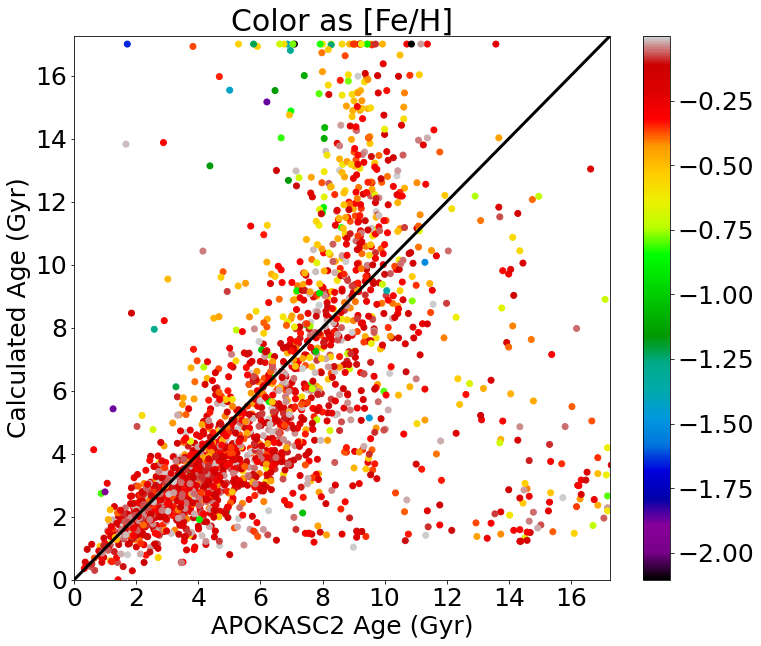

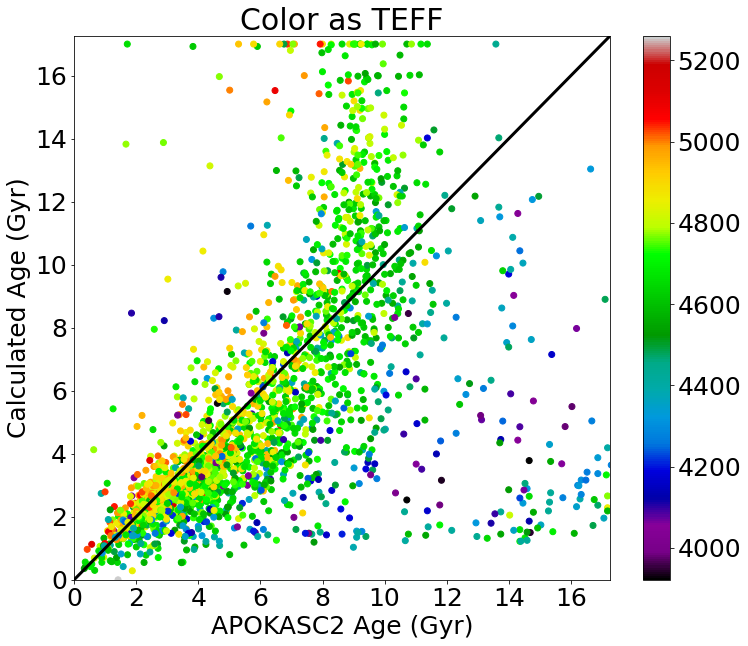

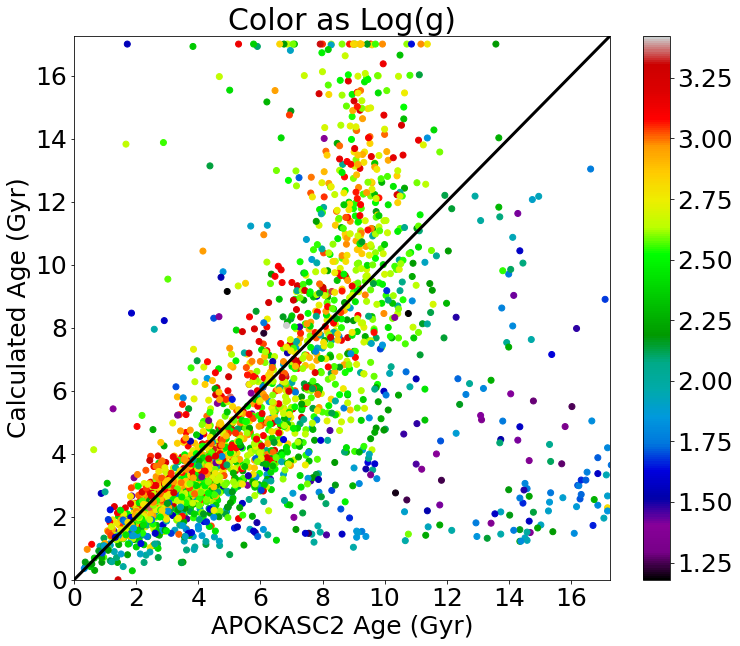

In [69]:
trends = np.array([kascdr17['FE_H'][ageevs][badcut],kascdr17['TEFF'][ageevs][badcut],
                   kascdr17['LOGG'][ageevs][badcut]])
trends_label = np.array(['[Fe/H]','TEFF','Log(g)'])
save_label = ['feh','teff','logg']

for i in range(len(trends)):

    plt.figure(figsize=[12,10])
    plt.scatter(x,y,c=trends[i],cmap='nipy_spectral')#,cmin=1)
    plt.colorbar()
    plt.plot([0,18],[0,18],c='k',lw=3.0)

    plt.xlim(0,17.25)
    plt.ylim(0,17.25)

    plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

    plt.title(r'Color as {}'.format(trends_label[i]))
    plt.xlabel('APOKASC2 Age (Gyr)')
    plt.ylabel('Calculated Age (Gyr)')
    plt.savefig('../plots/ageage{}_salaris.pdf'.format(save_label[i]),dpi=300,bbox_inches='tight')
    plt.show()

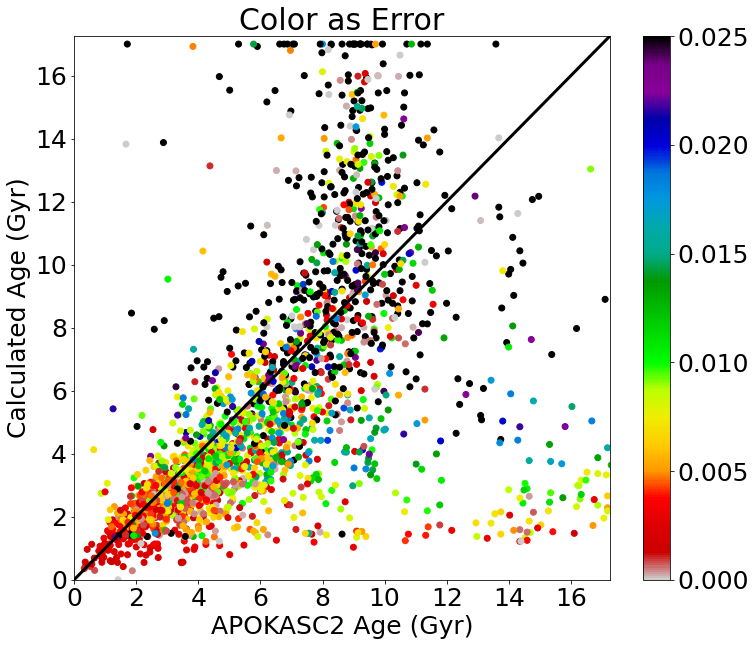

In [70]:
plt.figure(figsize=[12,10])
plt.scatter(x,y,c=kasc_age_err[badcut],cmap='nipy_spectral_r',vmax=(0.025))
plt.colorbar()
plt.plot([0,18],[0,18],c='k',lw=3.0)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.title(r'Color as Error')
plt.xlabel('APOKASC2 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
# plt.savefig('../plots/agegageerror.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Locus Slope

 
0.5718 x + 0.9779


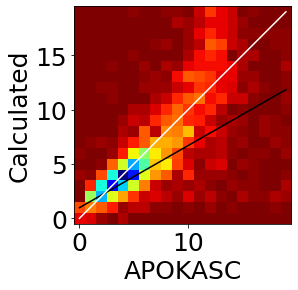

In [71]:
from scipy.stats import binned_statistic_2d
ret = binned_statistic_2d(x, y, x, 'count', bins=25)
agelocus = np.where((kasc_age<3)&(kasc['APOKASC2_AGE'][ageevs]<3))

p = np.poly1d(np.polyfit(kasc_age[agelocus],kasc['APOKASC2_AGE'][ageevs][agelocus],1))
print(p)

plt.imshow(ret.statistic.T[:20,:20],origin='bottom',cmap='jet_r')
plt.plot(np.arange(0,20),p(np.arange(0,20)),c='k')
plt.plot(np.arange(0,20),np.arange(0,20),c='white')
plt.savefig('slope2.pdf',dpi=300,bbox_inches='tight')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated')
plt.show()

# CMD HR around 10 Gyr

(0.0, 20.0)

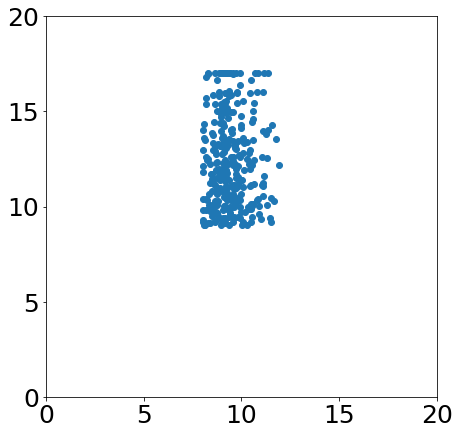

In [72]:
age10sel = np.where((kasc['APOKASC2_AGE'][ageevs]>8.0)&(kasc['APOKASC2_AGE'][ageevs]<12.)&
                    (kasc_age<20.)&(kasc_age>9))

plt.figure(figsize=[7,7])
plt.scatter(kasc['APOKASC2_AGE'][ageevs][age10sel],kasc_age[age10sel])
plt.xlim(0,20)
plt.ylim(0,20)

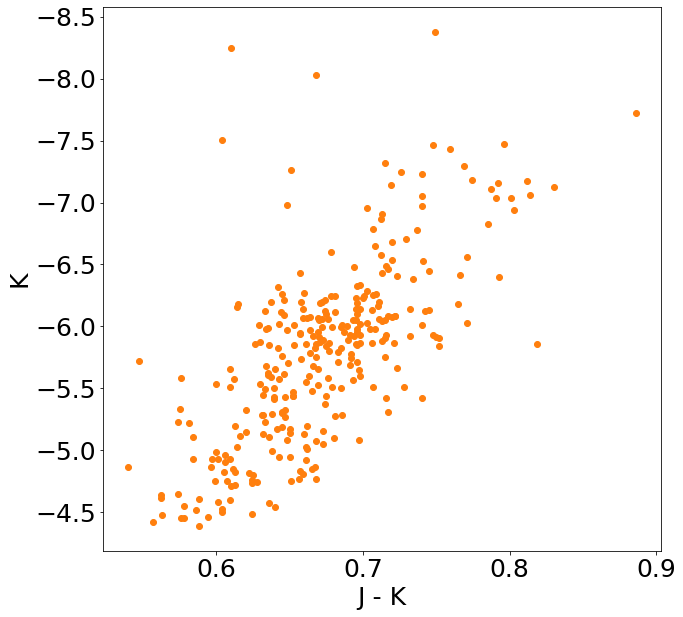

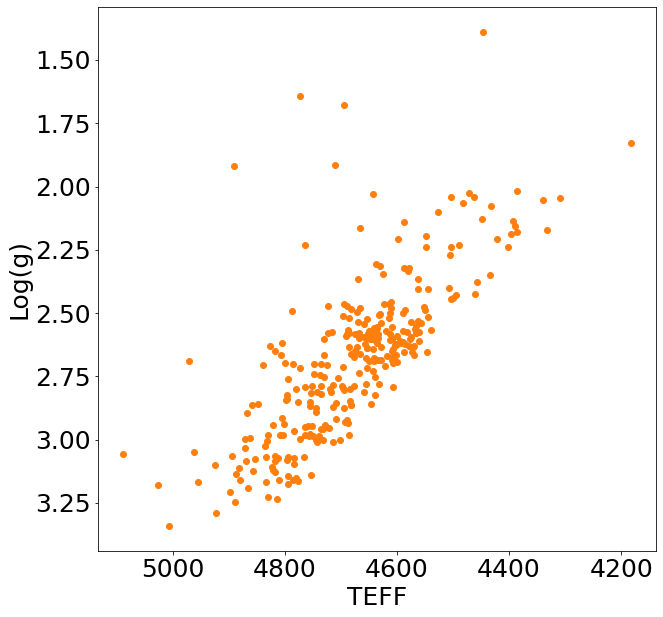

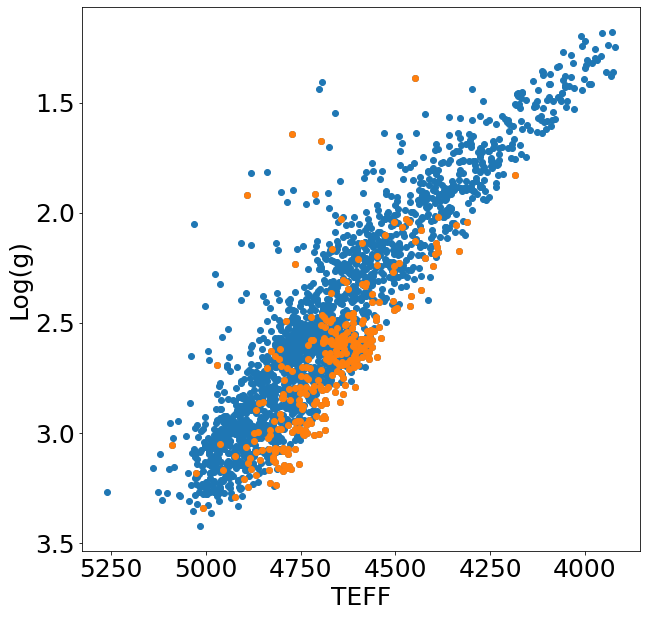

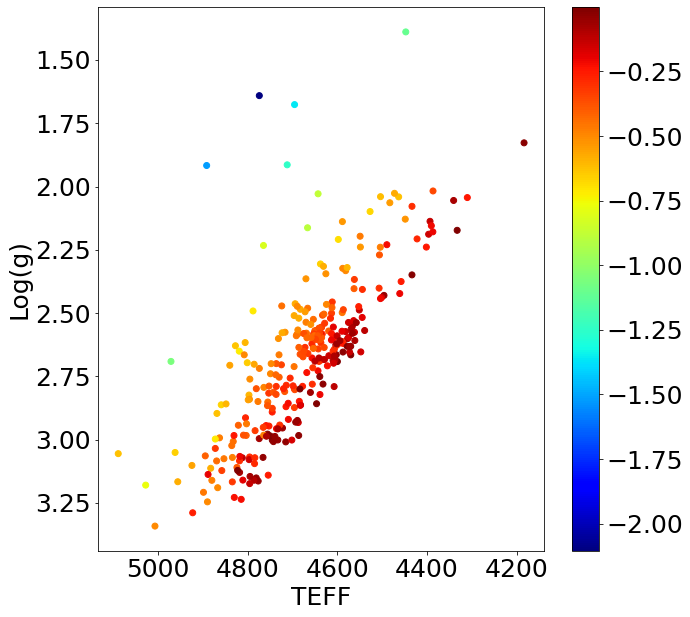

In [73]:
plt.figure(figsize=[10,10])
plt.scatter((kascdr17['J']-kascdr17['K'])[ageevs][age10sel],
            kascdr17[ageevs]['K'][age10sel]-5*np.log10( (1/kascdr17['GAIAEDR3_PARALLAX'][ageevs][age10sel])*1000),
            c='tab:orange')
plt.gca().invert_yaxis()
plt.xlabel('J - K')
plt.ylabel('K')
plt.savefig('2mass10Gyr_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(kascdr17['TEFF'][ageevs][age10sel],kascdr17[ageevs]['LOGG'][age10sel],c='tab:orange')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('TEFF')
plt.ylabel('Log(g)')
plt.savefig('HR10Gyr_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(kascdr17['TEFF'][ageevs],kascdr17['LOGG'][ageevs])
plt.scatter(kascdr17['TEFF'][ageevs][age10sel],kascdr17[ageevs][age10sel]['LOGG'])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('TEFF')
plt.ylabel('Log(g)')
plt.savefig('HR10Gyr+total_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(kascdr17['TEFF'][ageevs][age10sel],kascdr17[ageevs]['LOGG'][age10sel],
            c=kascdr17[ageevs]['FE_H'][age10sel],cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('TEFF')
plt.ylabel('Log(g)')
plt.savefig('HR10Gyrfeh_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Age Diff

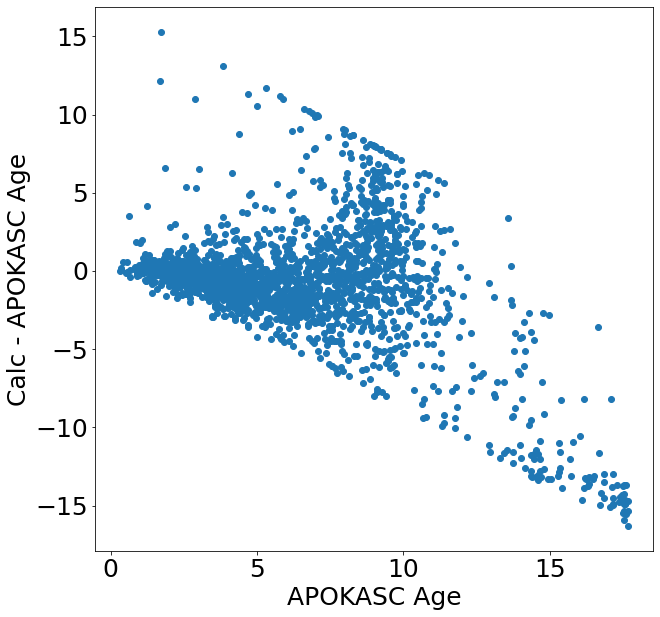

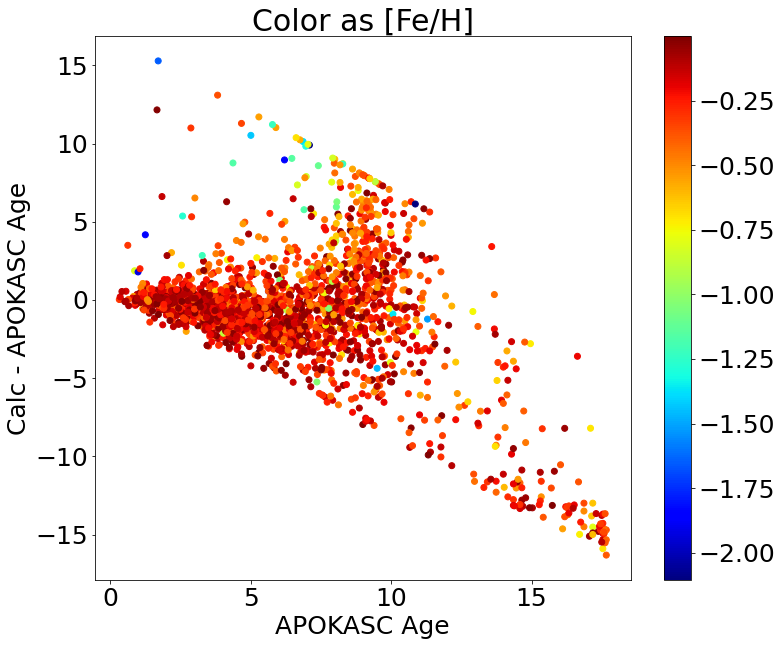

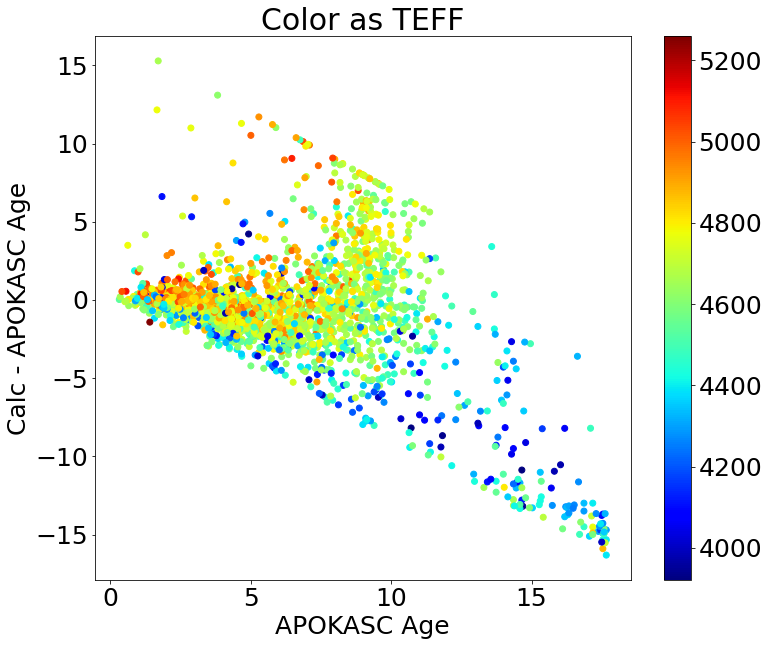

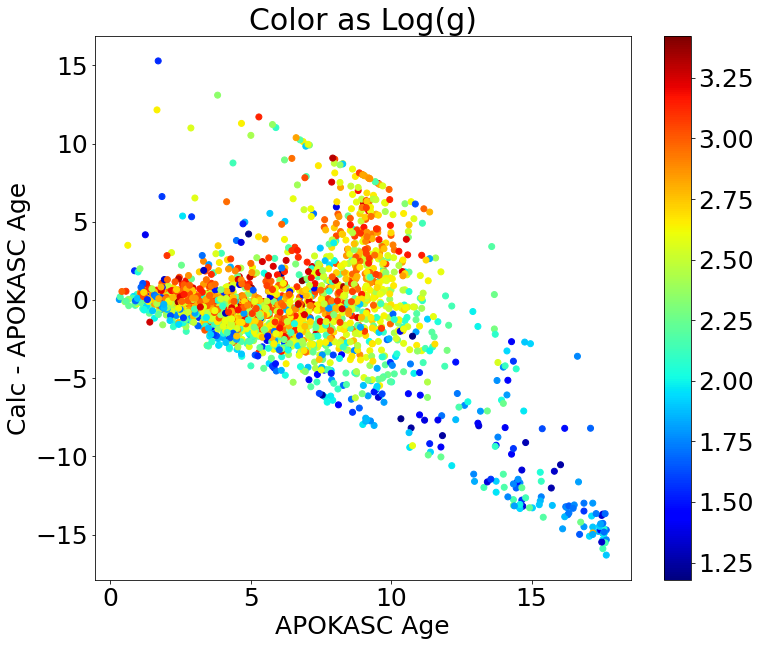

In [75]:
x = kasc['APOKASC2_AGE'][ageevs][badcut]
y = kasc_age[badcut]

plt.figure(figsize=[10,10])
plt.scatter(x,y-x)
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('diff_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(x,y-x,c=kascdr17['FE_H'][ageevs][badcut],cmap='jet')
plt.colorbar()
plt.title('Color as [Fe/H]')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('difffeh_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(x,y-x,c=kascdr17['TEFF'][ageevs][badcut],cmap='jet')
plt.colorbar()
plt.title('Color as TEFF')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('diffteff_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(x,y-x,c=kascdr17['logg'][ageevs][badcut],cmap='jet')
plt.colorbar()
plt.title('Color as Log(g)')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('difflogg_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()


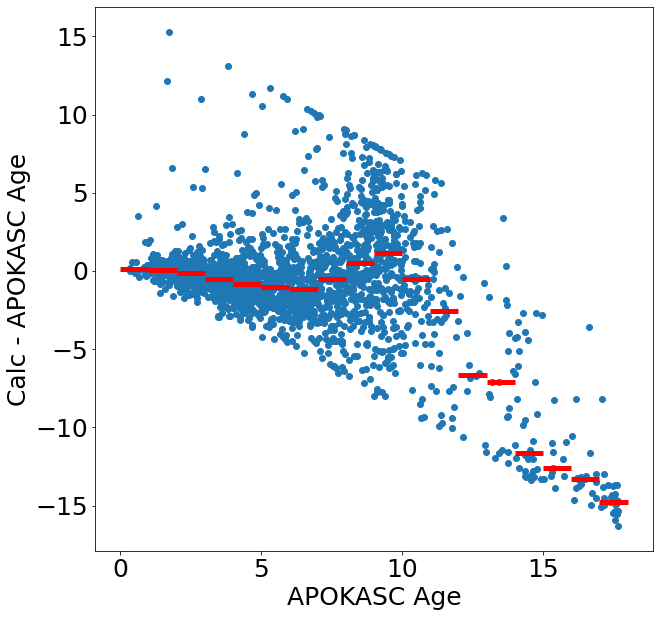

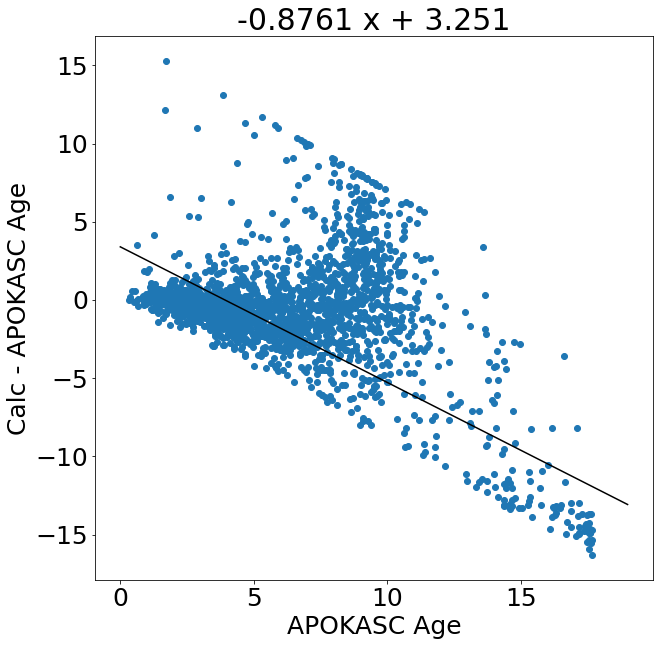

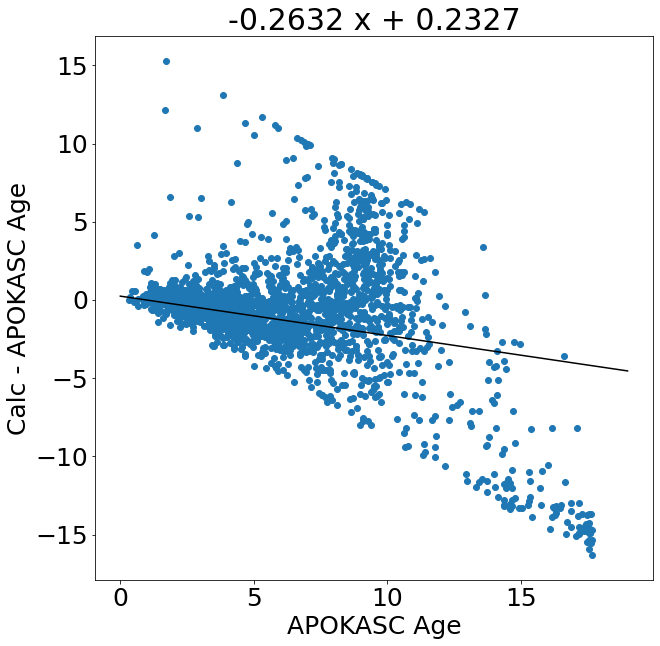

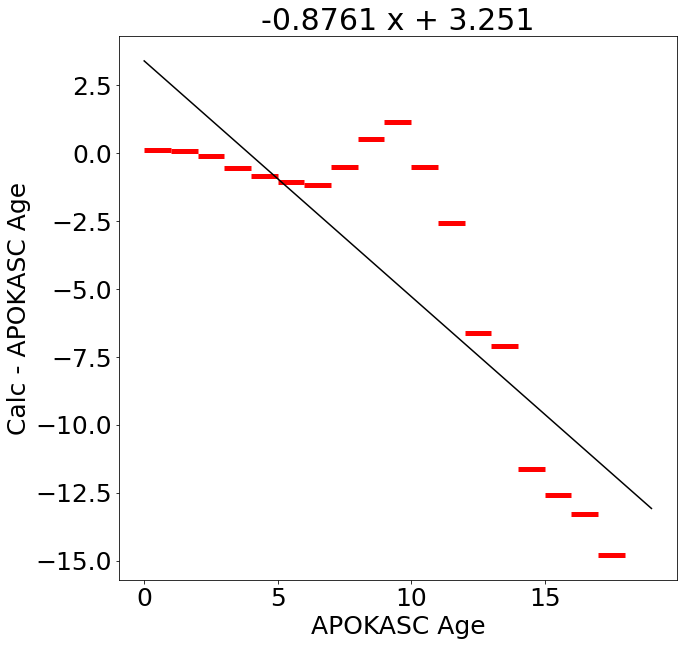

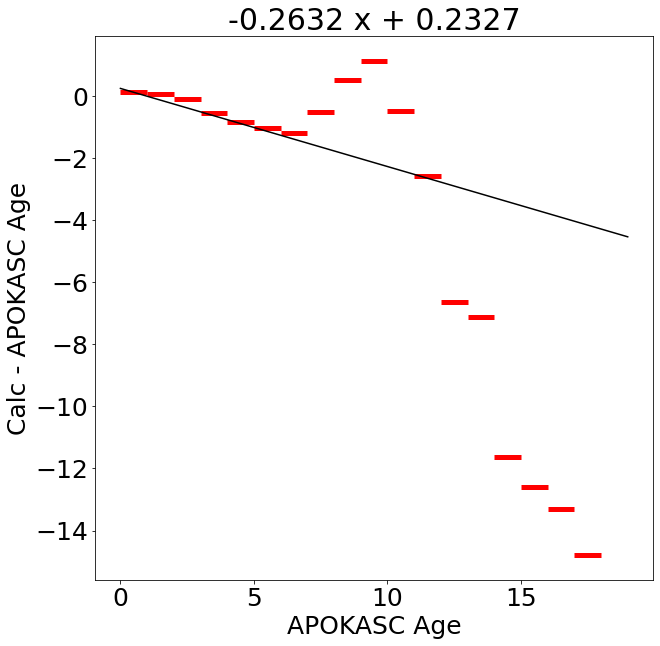

In [77]:
from scipy.stats import binned_statistic

x = kasc['APOKASC2_AGE'][ageevs][badcut]
y = kasc_age[badcut]

bin_means, bin_edges, binnumber = binned_statistic(x,y-x,statistic='median',bins=np.arange(20))

plt.figure(figsize=[10,10])
plt.scatter(x,y-x)#,label='raw data')
plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('residbins_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

residline = np.poly1d(np.polyfit(np.arange(20)[:-2],bin_means[:-1],1))

plt.figure(figsize=[10,10])
plt.scatter(x,y-x)#,label='raw data')
plt.plot(np.arange(20),residline(np.arange(20)),c='k')
plt.title(r'-0.8761 x + 3.251')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('wholeresidline_w_scatter_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

residline2 = np.poly1d(np.polyfit(np.arange(20)[:-2][:5],bin_means[:-1][:5],1))

plt.figure(figsize=[10,10])
plt.scatter(x,y-x)#,label='raw data')
plt.plot(np.arange(20),residline2(np.arange(20)),c='k')
plt.title(r'-0.2632 x + 0.2327')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('partresidline_w_scatter_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

residline = np.poly1d(np.polyfit(np.arange(20)[:-2],bin_means[:-1],1))

plt.figure(figsize=[10,10])
# plt.scatter(x,y-x)#,label='raw data')
plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.plot(np.arange(20),residline(np.arange(20)),c='k')
plt.title(r'-0.8761 x + 3.251')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('wholeresidline_w_bins_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

residline2 = np.poly1d(np.polyfit(np.arange(20)[:-2][:5],bin_means[:-1][:5],1))

plt.figure(figsize=[10,10])
# plt.scatter(x,y-x)#,label='raw data')
plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.plot(np.arange(20),residline2(np.arange(20)),c='k')
plt.title(r'-0.2632 x + 0.2327')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('partresidline_w_bins_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

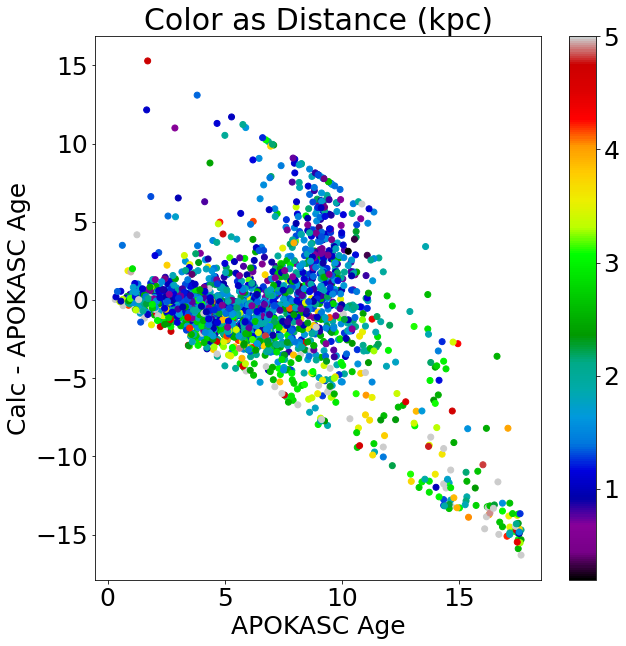

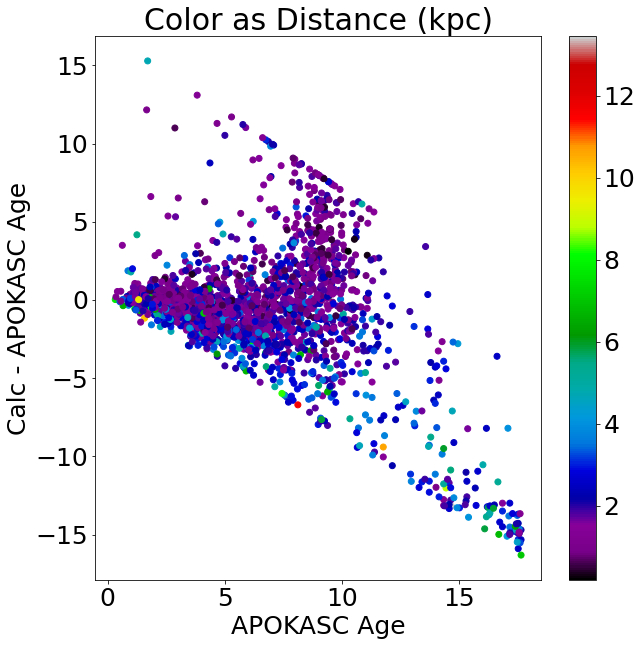

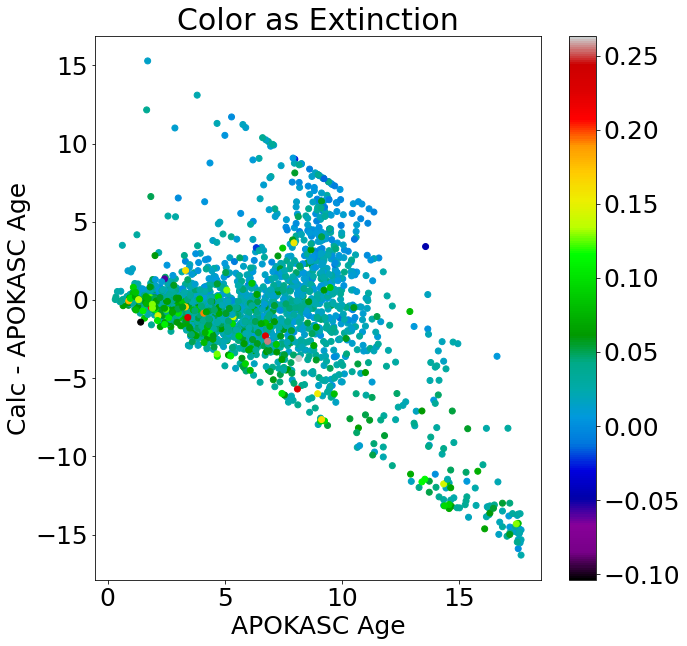

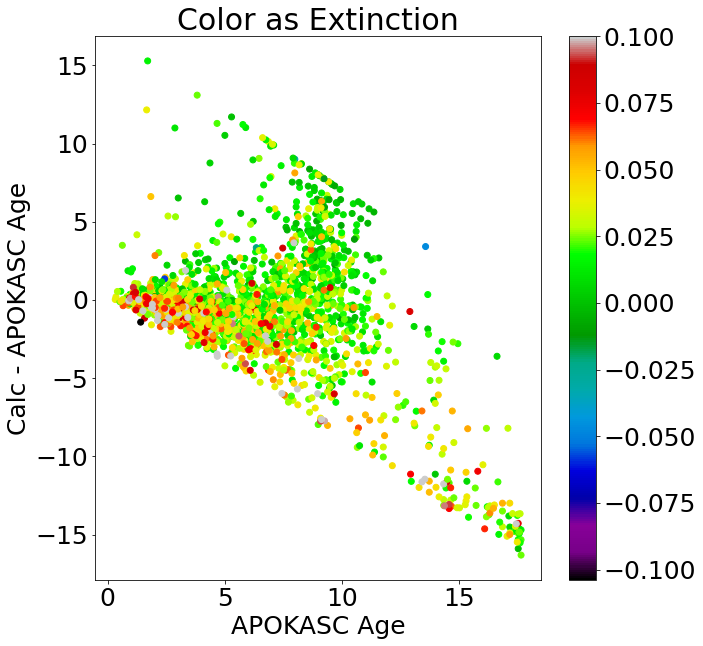

In [78]:
plt.figure(figsize=[10,10])
plt.scatter(x,y-x,c=1/kascdr17['GAIAEDR3_PARALLAX'][ageevs][badcut],cmap='nipy_spectral',vmax=5)
plt.colorbar()
# plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.title(r'Color as Distance (kpc)')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('residscatterdistance2_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(x,y-x,c=1/kascdr17['GAIAEDR3_PARALLAX'][ageevs][badcut],cmap='nipy_spectral')
plt.colorbar()
# plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.title(r'Color as Distance (kpc)')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('residscatterdistance_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(x,y-x,c=kasc_ak[badcut],cmap='nipy_spectral')
plt.colorbar()
# plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.title(r'Color as Extinction')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('residscatterextinction_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(x,y-x,c=kasc_ak[badcut],cmap='nipy_spectral',vmax=0.1)
plt.colorbar()
# plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.title(r'Color as Extinction')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('residscatterextinction2_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

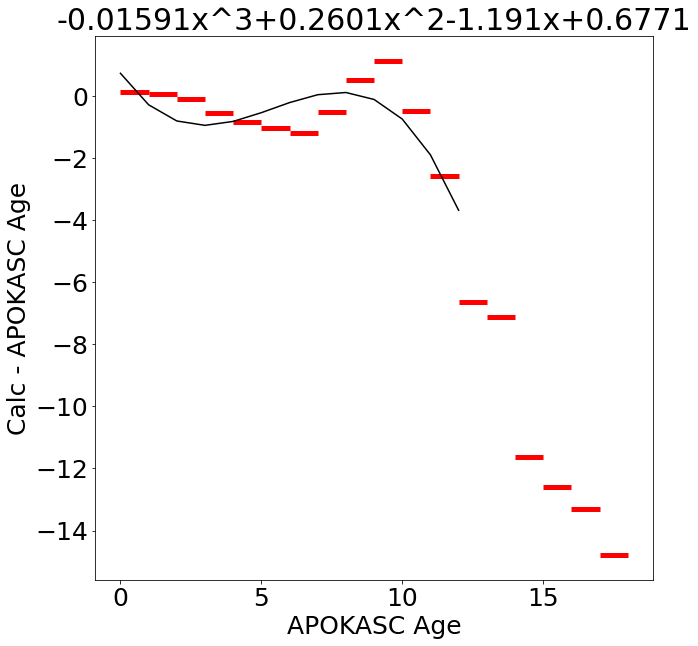

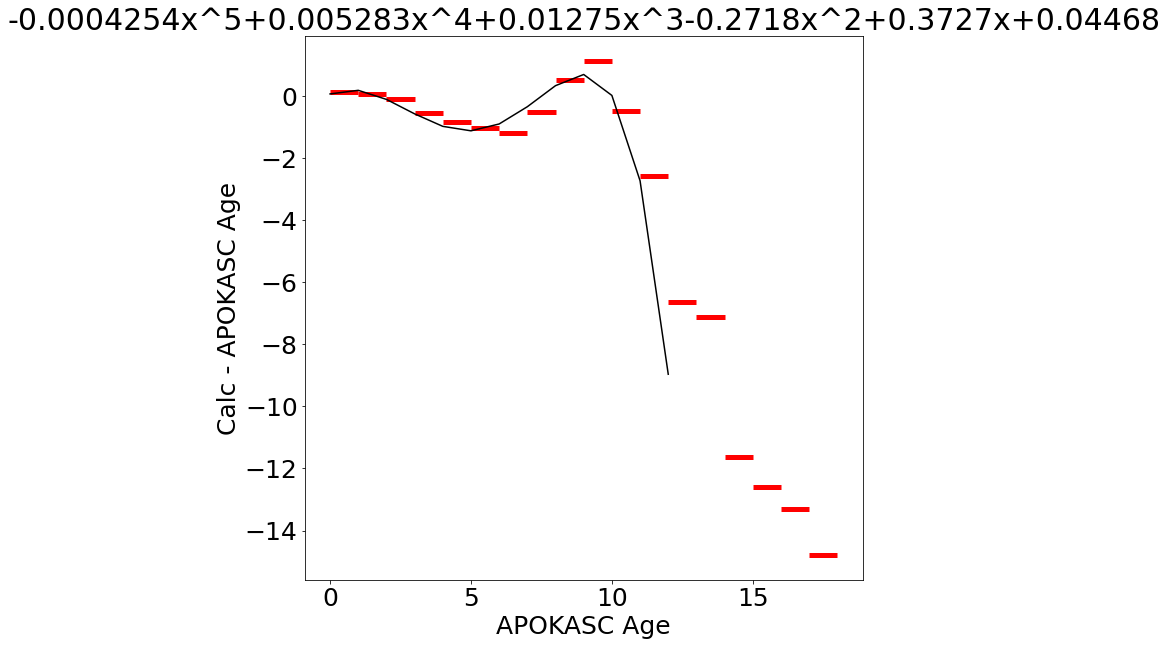

In [79]:
residcube = np.poly1d(np.polyfit(np.arange(20)[:-2][:12],bin_means[:-1][:12],3))

plt.figure(figsize=[10,10])
# plt.scatter(x,y-x)#,label='raw data')
plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.plot(np.arange(13),residcube(np.arange(13)),c='k')
plt.title(r'-0.01591x^3+0.2601x^2-1.191x+0.6771')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('partresidcube_w_bins_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

residquin = np.poly1d(np.polyfit(np.arange(20)[:-2][:12],bin_means[:-1][:12],5))

plt.figure(figsize=[10,10])
# plt.scatter(x,y-x)#,label='raw data')
plt.hlines(bin_means,bin_edges[:-1], bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.plot(np.arange(13),residquin(np.arange(13)),c='k')
plt.title(r'-0.0004254x^5+0.005283x^4+0.01275x^3-0.2718x^2+0.3727x+0.04468')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('partresidquin_w_bins_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [80]:
bin_mads, _, _ = binned_statistic(x,y-x,statistic=lambda y: np.nanmedian(np.abs(y-np.nanmedian(y))),
                                  bins=np.arange(20))

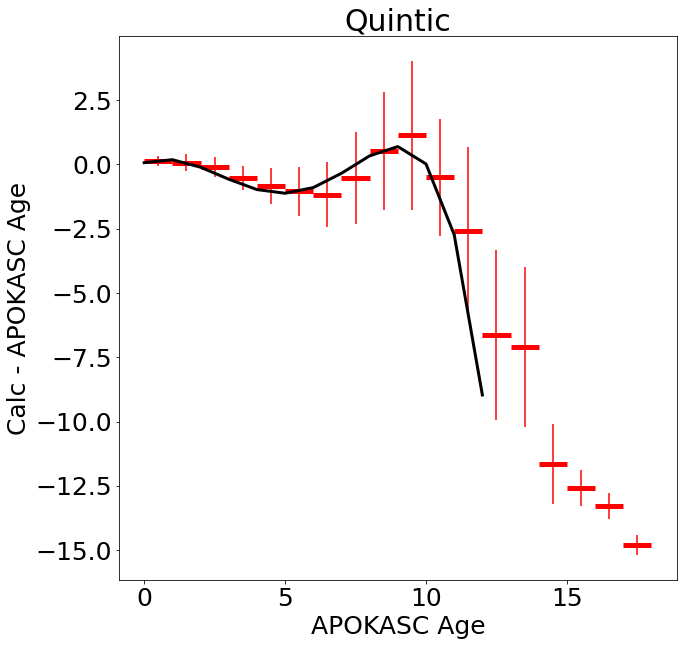

In [81]:
residquin = np.poly1d(np.polyfit(np.arange(20)[:-2][:12],bin_means[:-1][:12],5))

plt.figure(figsize=[10,10])
# plt.scatter(x,y-x)#,label='raw data')
plt.hlines(bin_means,bin_edges[:-1],bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.errorbar(np.arange(19)+0.5,bin_means,yerr=bin_mads,c='r',ls=' ')
plt.plot(np.arange(13),residquin(np.arange(13)),c='k',lw=3.0)
plt.title(r'Quintic')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('partresidquin_w_bins_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

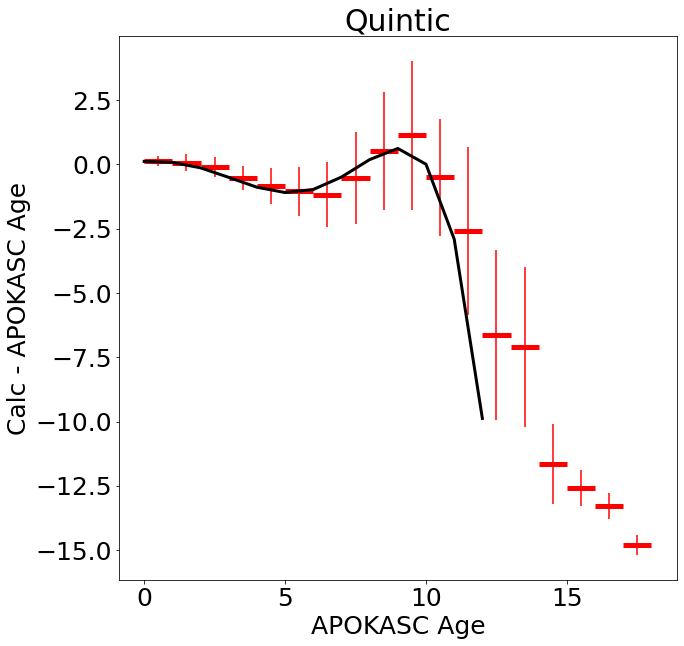

In [82]:
residquin2 = np.poly1d(np.polyfit(np.arange(20)[:-2][:12],bin_means[:-1][:12],5,w=1/bin_mads[:-1][:12]))

plt.figure(figsize=[10,10])
# plt.scatter(x,y-x)#,label='raw data')
plt.hlines(bin_means,bin_edges[:-1],bin_edges[1:], colors='r',lw=5,label='binned statistic of data')
plt.errorbar(np.arange(19)+0.5,bin_means,yerr=bin_mads,c='r',ls=' ')
plt.plot(np.arange(13),residquin2(np.arange(13)),c='k',lw=3.0)
plt.title(r'Quintic')
plt.xlabel('APOKASC Age')
plt.ylabel(r'Calc - APOKASC Age')
plt.savefig('partresidquin2_w_bins_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

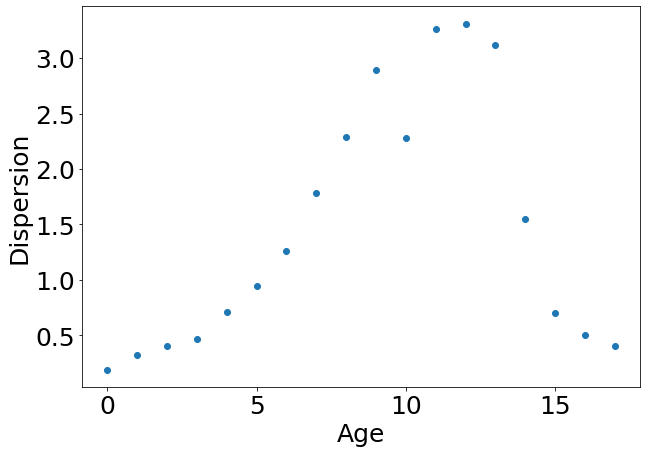

In [83]:
plt.figure(figsize=[10,7])
plt.scatter(np.arange(20)[:-1],bin_mads)
plt.xlabel('Age')
plt.ylabel('Dispersion')
plt.savefig('agedisp_salaris_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

(array([2.049e+03, 1.480e+02, 7.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <a list of 10 Patch objects>)

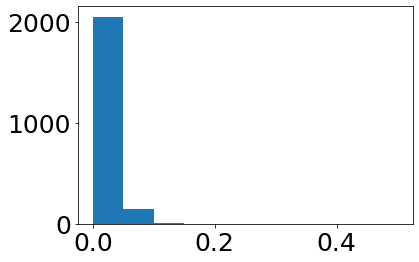

In [84]:
plt.hist(np.sqrt(kasc_age_err**2+0.025**2),range=(0,0.5))

(array([4.645e+03, 1.402e+03, 3.050e+02, 8.000e+01, 3.800e+01, 1.800e+01,
        1.000e+01, 6.000e+00, 4.000e+00, 2.000e+00]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ],
       dtype=float32),
 <a list of 10 Patch objects>)

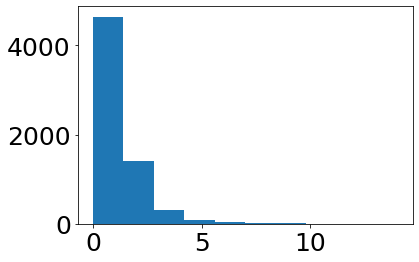

In [85]:
fin_err = np.where((np.isfinite(kasc['APOKASC2_AGE_PERR'])==True)&(kasc['APOKASC2_AGE_PERR']>-100.))
plt.hist(kasc['APOKASC2_AGE_PERR'][fin_err],range=(0,14))


0.09393518


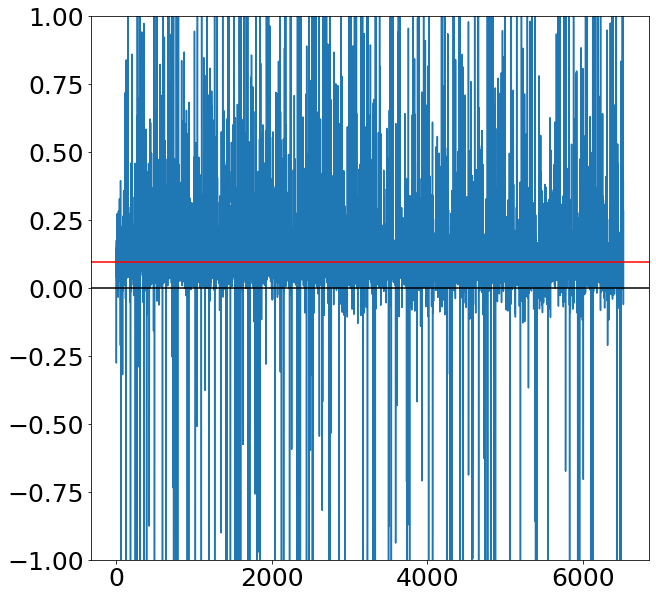

In [86]:
plt.figure(figsize=[10,10])
plt.plot((kasc['APOKASC2_AGE_PERR'][fin_err]-kasc['APOKASC2_AGE_MERR'][fin_err])/2.)
plt.axhline(0.,c='k')
plt.axhline(np.median((kasc['APOKASC2_AGE_PERR'][fin_err]-kasc['APOKASC2_AGE_MERR'][fin_err])/2.),c='r')
plt.ylim(-1,1)
print(np.median((kasc['APOKASC2_AGE_PERR'][fin_err]-kasc['APOKASC2_AGE_MERR'][fin_err])/2.))

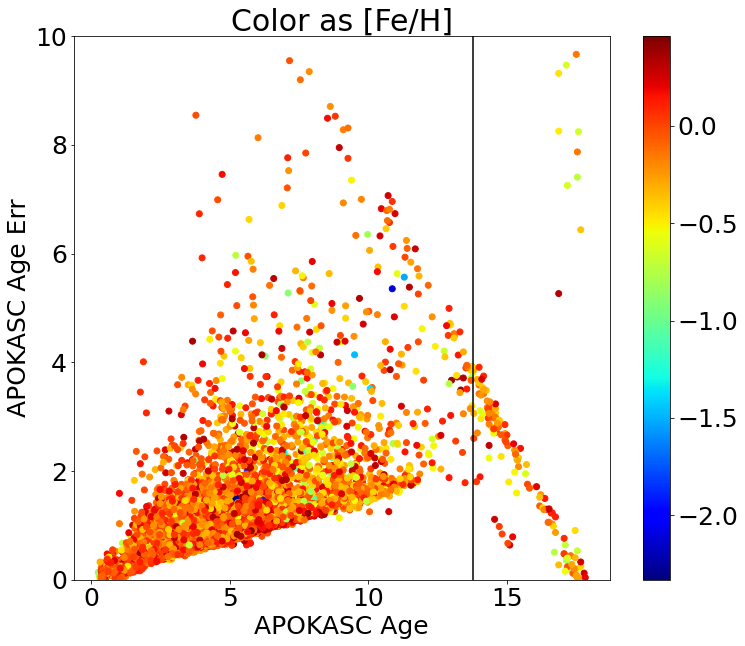

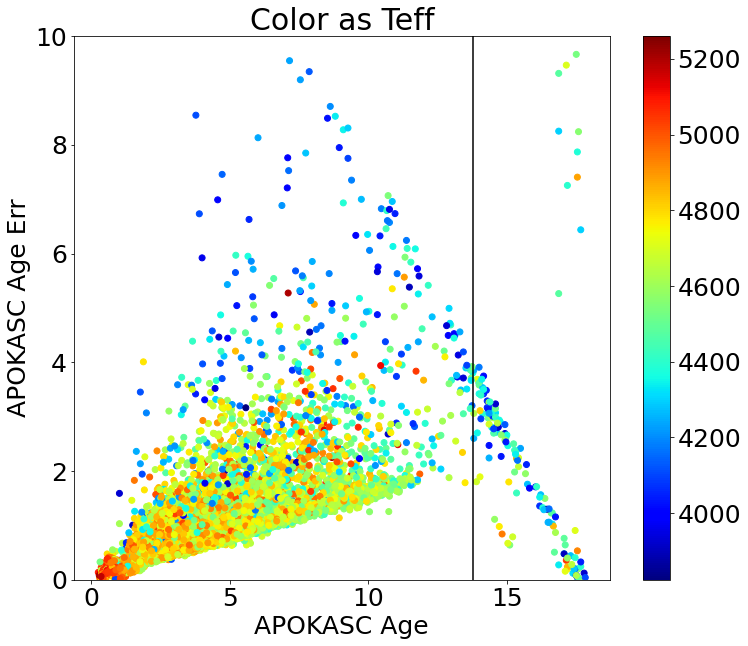

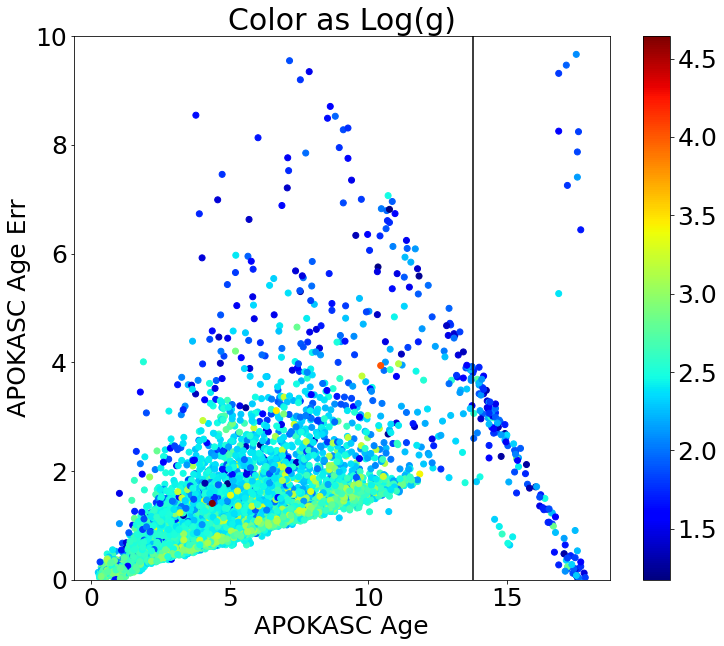

In [87]:
plt.figure(figsize=[12,10])
plt.scatter(kasc['APOKASC2_AGE'][fin_err],kasc['APOKASC2_AGE_PERR'][fin_err],
            c=kascdr17['FE_H'][fin_err],cmap='jet')
plt.colorbar()
plt.ylim(0,10)
plt.axvline(13.772,c='k')
plt.title('Color as [Fe/H]')
plt.xlabel(r'APOKASC Age')
plt.ylabel(r'APOKASC Age Err')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(kasc['APOKASC2_AGE'][fin_err],kasc['APOKASC2_AGE_PERR'][fin_err],
            c=kascdr17['TEFF'][fin_err],cmap='jet')
plt.colorbar()
plt.ylim(0,10)
plt.axvline(13.772,c='k')
plt.title('Color as Teff')
plt.xlabel(r'APOKASC Age')
plt.ylabel(r'APOKASC Age Err')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(kasc['APOKASC2_AGE'][fin_err],kasc['APOKASC2_AGE_PERR'][fin_err],
            c=kascdr17['LOGG'][fin_err],cmap='jet')
plt.colorbar()
plt.ylim(0,10)
plt.axvline(13.772,c='k')
plt.title('Color as Log(g)')
plt.xlabel(r'APOKASC Age')
plt.ylabel(r'APOKASC Age Err')
plt.show()

(array([ 14.,  40., 139., 182., 251., 250., 211., 137., 124., 101.,  77.,
         70.,  71.,  64.,  61.,  50.,  64.,  38.,  37.,  28.,  36.,  23.,
         24.,  14.,  18.]),
 array([ 0.  ,  0.56,  1.12,  1.68,  2.24,  2.8 ,  3.36,  3.92,  4.48,
         5.04,  5.6 ,  6.16,  6.72,  7.28,  7.84,  8.4 ,  8.96,  9.52,
        10.08, 10.64, 11.2 , 11.76, 12.32, 12.88, 13.44, 14.  ]),
 <a list of 25 Patch objects>)

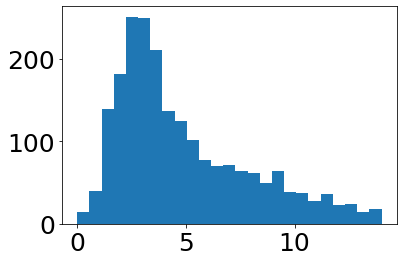

In [277]:
plt.hist(kasc_age,range=(0,14),bins=25)

Text(0.5, 0, 'Calculated Aetas Age Error')

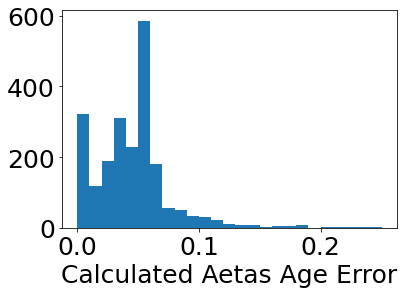

In [37]:
plt.hist(kasc_age_err,bins=25,range=(0,0.25))
plt.xlabel(r'Calculated Aetas Age Error')